# this notebook combined DALI data pipeline + model training in one go 
## datapipeline 2525x2525x3 --> 800x800x3 --> 224x224 x3
### first check that synthetically made image data given shape  2525 x 2525 x 3
## go to launch and type in **watch -n 1 nvidia-smi** in order to monitor the GPU utils as I showcased in the demo

In [1]:
### reference url :https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/tensorflow/tensorflow-dataset.html 
### https://github.com/NVIDIA/DALI/blob/master/docs/examples/frameworks/tensorflow/tensorflow-dataset.ipynb

In [2]:
# validate synthetically created image size is 2525x2525x3 
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
c=random.sample(os.listdir('/workspace/Data'),1)
random_img=random.sample(os.listdir('/workspace/Data/'+c[0]),1)
test=plt.imread('/workspace/Data/'+c[0]+'/'+random_img[0])
print(test.shape)

(2525, 2525, 3)


In [3]:
## make label so it is easier to visualize and do plotting 
#import tensorflow as tf
#tf.debugging.set_log_device_placement(True)
label2num={'notHappy':0,'Happy':1,'others':2}
num2label=dict([(b,a) for (a,b) in label2num.items()])
device_id=0


In [4]:
!tail bigimgs_path.txt

/workspace/Data/others/others_90.png 2
/workspace/Data/others/others_91.png 2
/workspace/Data/others/others_92.png 2
/workspace/Data/others/others_93.png 2
/workspace/Data/others/others_94.png 2
/workspace/Data/others/others_95.png 2
/workspace/Data/others/others_96.png 2
/workspace/Data/others/others_97.png 2
/workspace/Data/others/others_98.png 2
/workspace/Data/others/others_99.png 2


---------------------------------------------------------------------------------------------------------------

# === next we add flip+ **rotate** + resize to 224x224x3  and create a new pipeline named Opt3Pipeline ===
## run through notebook = **resize2big_image.ipynb** to create corresponding director file= **bigimgs_path.txt**

In [5]:
import tensorflow as tf

import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline
Yes_rotate=True
batch_size = 4
class Opt3Pipeline(Pipeline):
    def __init__(self, img_file_list,  num_shards, shard_id, batch_size, num_threads, device_id, Yes_rotate):
        super(Opt3Pipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input_img = ops.FileReader(file_root = "", num_shards=num_shards, shard_id=shard_id, file_list=img_file_list,random_shuffle = True, initial_fill = 21)
        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        self.rrc = ops.RandomResizedCrop(
                device="gpu",
                size=(800,800),
                random_area=[0.8, 0.8])
        self.flip_h = ops.Flip(device = "gpu", vertical = 0, horizontal = 1)
        if Yes_rotate:
            self.resize1=ops.Resize(device="gpu", resize_x=224*math.sqrt(2), resize_y=224*math.sqrt(2))
            self.rotate = ops.Rotate(device = "gpu", angle = 15*random.randint(0,24), interp_type = types.INTERP_LINEAR, fill_value = 0) # one can indicate what other fill_value you want
            self.resize = ops.Resize(device="gpu", resize_x=224, resize_y=224)
        


    def define_graph(self):
        imgs, labels = self.input_img()
        images = self.decode(imgs)
        output = self.rrc(images)
        output = self.flip_h(output)
        if Yes_rotate:
            output = self.resize1(output)
            output = self.rotate(output)
            output = self.resize(output)
        return (output, labels)

pipe3 = Opt3Pipeline("bigimgs_path.txt", 2, 0, batch_size, 8, 0,Yes_rotate)

pipe3.build()

images3, labels3 = pipe3.run()
len_outputs = 8

imgs3=np.array(images3.as_cpu().as_tensor())
print(imgs3.shape)
mas3=np.array(labels3.as_tensor())
print(type(imgs3),type(mas3))
print(imgs3.shape, mas3.shape)

(4, 224, 224, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(4, 224, 224, 3) (4, 1)


(224, 224, 3)
[1]


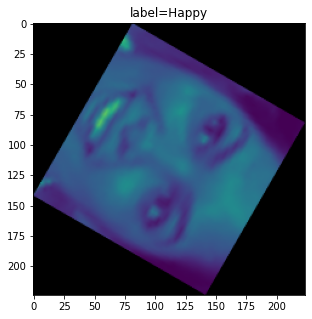

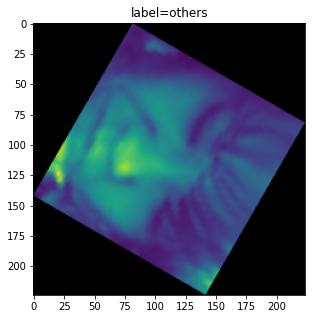

In [6]:
### visualize once only, moving image back to CPU is expensive, we dont do that when we using DALI to pipe data directly into model ( which is ALSO on GPU =0)
print(imgs3[0].shape)
print(mas3[0])
show_many=2
for i in range(show_many):
    im=imgs3[i].reshape(224,224,3)
    label=mas3[i][0]
    plt.figure(figsize = (5,5))
    plt.imshow(im)
    plt.title("label={}".format(num2label[label]))

    plt.show()
del pipe3 # to free some gpu memory

In [7]:
import tensorflow  as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow.compat.v1 as tf
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.plugin.tf as dali_tf
tf.logging.set_verbosity(tf.logging.ERROR)
batch_size=2
pipe4 = Opt3Pipeline("bigimgs_path.txt", 2, 0, batch_size, 8, 0, Yes_rotate)
def get_reset50_model():
    # load model without classifier layers
    num_class=3
    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

    # make all layers trainable
    for layer in base_model.layers:
        layer.trainable = True
    # add your head on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_class, activation='softmax')(x)

    m = Model(inputs=base_model.input, outputs=output)
    return m
    
with tf.device('/gpu:0'):
    
    daliop = dali_tf.DALIIterator()
    # Define shapes and types of the outputs
    # Define shapes and types of the outputs
    shapes = [
        (2, 224, 224,3),
        (2,1)]
    dtypes = [
        tf.float32,
        tf.int32]


    # Create tensorflow dataset

    out_dataset = dali_tf.DALIDataset(
        pipeline=pipe4,
        batch_size=batch_size,
        shapes=shapes,
        dtypes=dtypes,
        device_id=0)

    m=get_reset50_model()
    m.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    # Train using DALI dataset
    m.fit(
        out_dataset,
        epochs=50,
        steps_per_epoch=8*8,
        use_multiprocessing=True
    )

Executing op DALIDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas